In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from textwrap import fill
from cycler import cycler
import math


In [2]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

from utils.common_functions import save_or_show, load_df


Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


# Deployment

In [3]:
CUSTOM_CAH = ("10")
TITLE = "Distribution of Engineering Students by Discipline (2023)"
YLABEL = "Enrolments"
path = r"../data/table-52.2023"

In [4]:
df = load_df(path, skip_rows=13)

In [5]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "font.family": "DejaVu Sans",
    })

In [6]:
def keep_totals_slice(df):
    mask = (
        df["CAH level marker"].eq("CAH level 3") &
        df["Entrant marker"].eq("All") &
        df["Level of study"].eq("All") &
        df["Mode of study"].eq("All") &
        df["Permanent address marker"].eq("Total")
    )
    d = df.loc[mask].copy()
    return d

In [7]:

def filter_scope(d, custom=("10", "11", "13")):
    keep = d["CAH level subject"].str.startswith(custom, na=False)
    df_keep = d[keep].copy()
    return df_keep

In [8]:
def ensure_subject_label_has_no_code(d):
    if "Subject" not in d.columns:
        d["Subject"] = d["CAH level subject"].str.replace(
            r"^\s*\d{2}-\d{2}-\d{2}\s+", "", regex=True
        ).str.strip()
    return d

In [9]:
def filter(df_, cah):
    d = filter_scope(df_, custom=cah)
    d = ensure_subject_label_has_no_code(d)
    return d

In [10]:
def plot_pie_2023(
    d, out_basename: str, title: str, top_n_pie: int = 9, chart_dir="chart-2"
):
    publication_rc()

    sub = (d.groupby("Subject", as_index=False)["Number"]
             .sum()
             .sort_values("Number", ascending=False))

    keep = sub.head(top_n_pie).copy()
    other_sum = sub.iloc[top_n_pie:]["Number"].sum()
    if other_sum > 0:
        keep.loc[len(keep)] = ["Other subjects", other_sum]

    palette = (
        list(plt.cm.tab20.colors) +
        list(plt.cm.Set2.colors)  +
        list(plt.cm.Paired.colors)
    )

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_prop_cycle(cycler(color=palette))

    sizes  = keep["Number"].to_numpy()
    labels = keep["Subject"].tolist()

    def pct_or_blank(p, threshold=3.0):
        return f"{p:.1f}%" if p >= threshold else ""

    wedges, _texts, autotexts = ax.pie(
        sizes,
        labels=None,
        startangle=90, counterclock=False,
        autopct=lambda p: pct_or_blank(p, 3.0),
        pctdistance=0.75,
        wedgeprops=dict(linewidth=0.8, edgecolor="white"),
        textprops=dict(fontsize=12)
    )
    ax.axis("equal")

    ax.set_title(title, fontweight="bold", pad=6)
    leg = ax.legend(
        wedges, labels,
        title="Subjects",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )
    
    leg.get_title().set_fontweight("bold")
    leg._legend_box.align = "left"

    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)


In [11]:
def plot_bar_2023( d: pd.DataFrame, out_basename: str, title: str, top_n_bar: int = 20, chart_dir: str = "chart-2"): 
    publication_rc()
    sub = (d.groupby("Subject", as_index=False)["Number"]
             .sum()
             .sort_values("Number", ascending=False))
    sub_bar = sub.head(top_n_bar).copy()
    n = len(sub_bar)

    fig_w = max(10, 0.7 * n)
    fig, ax = plt.subplots(figsize=(fig_w, 6.5))

    base_palette = (
        list(plt.cm.tab20.colors) +
        list(plt.cm.Set2.colors)  +
        list(plt.cm.Paired.colors)
    )
    colors = (base_palette * ((n // len(base_palette)) + 1))[:n]

    BAR_WIDTH = 0.65
    bars = ax.bar(
        sub_bar["Subject"],
        sub_bar["Number"],
        color=colors,
        width=BAR_WIDTH,
        linewidth=0
    )

    y_max = sub_bar["Number"].max()
    ax.set_ylim(0, y_max * 1.15)

    lbls = ax.bar_label(bars, fmt="{:,.0f}", padding=3, label_type="edge")
    for t in lbls:
        t.set_clip_on(False)
        t.set_fontsize(10)

    ax.set_xticklabels(sub_bar["Subject"], rotation=30, ha="right")

    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.grid(True, axis="y", which="major", linestyle="--", alpha=0.4)

    ax.set_xlabel("")
    ax.set_ylabel("Enrolments", fontweight="bold", labelpad=8)
    ax.set_title(title, fontweight="bold", pad=12)

    plt.tight_layout()
    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)


In [12]:
df_keep = keep_totals_slice(df)
d_eng = filter(df_keep, CUSTOM_CAH)

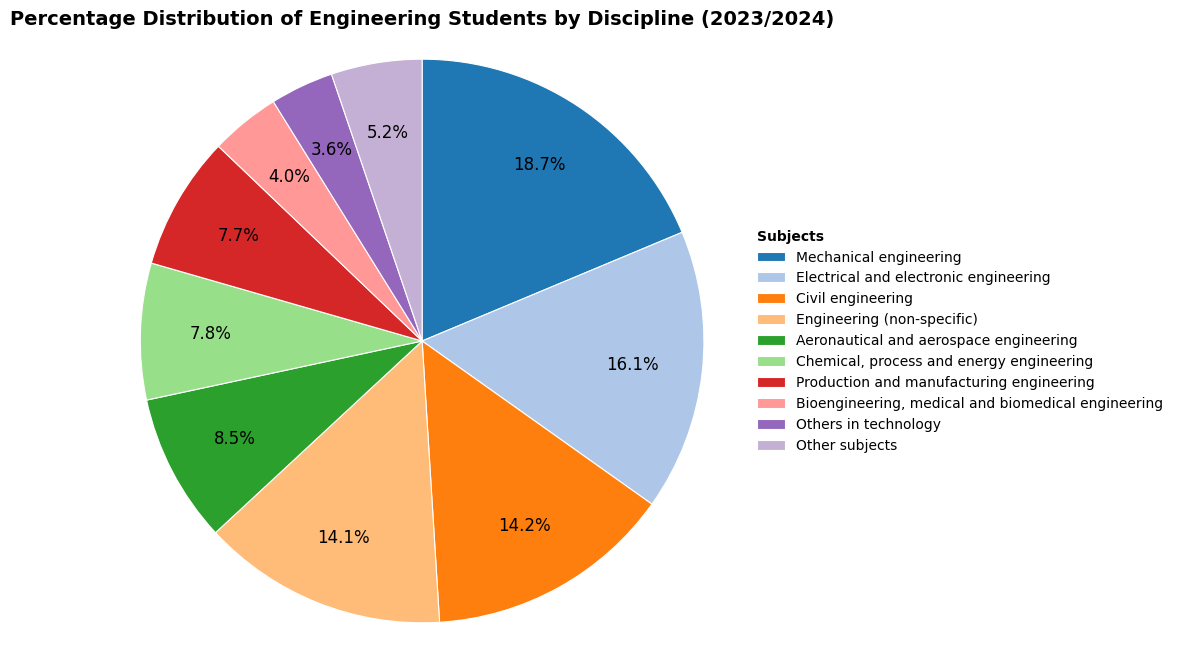

C:\Users\faith.SCCNIG\AppData\Local\Temp\ipykernel_202392\3904361733.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_bar["Subject"], rotation=30, ha="right")


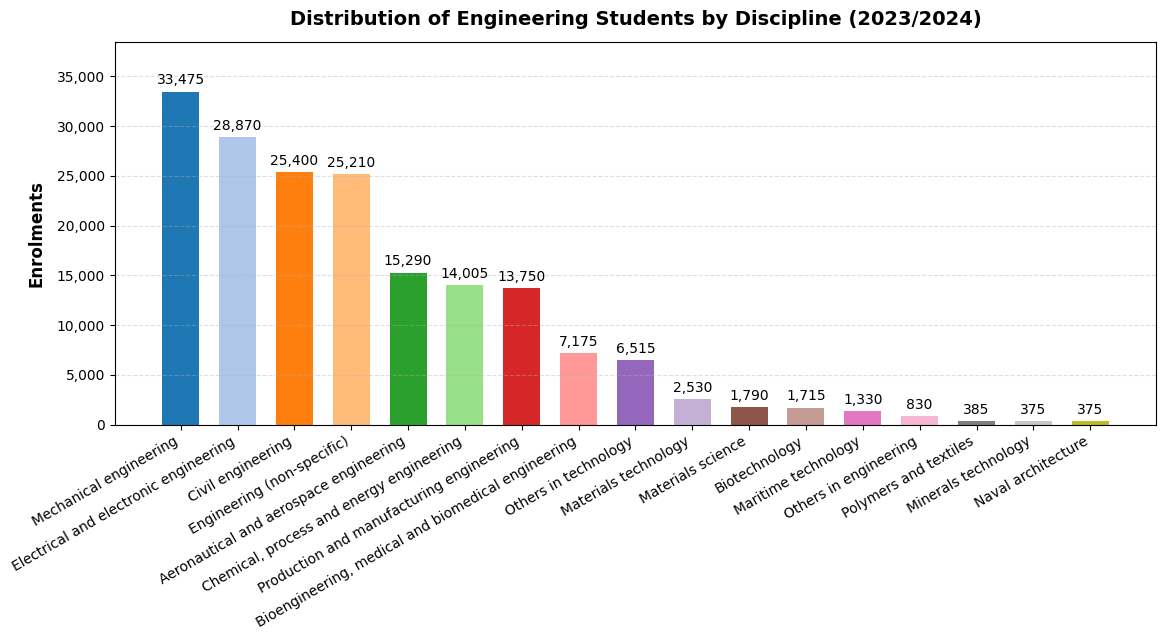

In [13]:
plot_pie_2023(
    d_eng,
    out_basename="eng_students_2023_pie",
    title="Percentage Distribution of Engineering Students by Discipline (2023/2024)",
)

plot_bar_2023(
    d_eng,
    out_basename="eng_students_2023_bar",
    title="Distribution of Engineering Students by Discipline (2023/2024)",
)
